# Import libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuration

In [2]:
window_size = 7
lstm_epochs = 20

# Data Collection

In [3]:
def fetch_historical_data(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

# Fetch data for different intervals
df_1m = fetch_historical_data('BTCUSDT', '1m')
df_1h = fetch_historical_data('BTCUSDT', '1h')
df_4h = fetch_historical_data('BTCUSDT', '4h')
df_1d = fetch_historical_data('BTCUSDT', '1d')

# Data Preparation

In [4]:
def prepare_data(data):
    data['returns'] = data['close'].pct_change()
    data.dropna(inplace=True)
    return data

In [5]:
# Prepare data
df_1m = prepare_data(df_1m)
df_1h = prepare_data(df_1h)
df_4h = prepare_data(df_4h)
df_1d = prepare_data(df_1d)

# Data Preprocessing

In [6]:
def split_data(df, type):
    data = df[type]
    train_data = data.iloc[:int(len(data)*0.8)]
    test_data = data.iloc[int(len(data)*0.8):]
    train_label = train_data.shift(-window_size).dropna()
    train_label.iloc[-1] = test_data.iloc[0]
    test_label = test_data.shift(-window_size).dropna()
    return np.array(train_data), np.array(train_label), np.array(test_data), np.array(test_label)

In [7]:
def extract_features_sliding_window(data, window_size):
    features = []
    for i in range(len(data) - window_size):
        features.append(data[i:i+window_size])
    return np.array(features)

In [8]:
scaler_1m_price = StandardScaler()
scaler_1h_price = StandardScaler()
scaler_4h_price = StandardScaler()
scaler_1d_price = StandardScaler()

scaler_1m_returns = StandardScaler()
scaler_1h_returns = StandardScaler()
scaler_4h_returns = StandardScaler()
scaler_1d_returns = StandardScaler()

In [9]:
df_1m['normalized_close'] = scaler_1m_price.fit_transform(df_1m['close'].values.reshape(-1, 1))
df_1h['normalized_close'] = scaler_1h_price.fit_transform(df_1h['close'].values.reshape(-1, 1))
df_4h['normalized_close'] = scaler_4h_price.fit_transform(df_4h['close'].values.reshape(-1, 1))
df_1d['normalized_close'] = scaler_1d_price.fit_transform(df_1d['close'].values.reshape(-1, 1))

df_1m['normalized_returns'] = scaler_1m_returns.fit_transform(df_1m['returns'].values.reshape(-1, 1))
df_1h['normalized_returns'] = scaler_1h_returns.fit_transform(df_1h['returns'].values.reshape(-1, 1))
df_4h['normalized_returns'] = scaler_4h_returns.fit_transform(df_4h['returns'].values.reshape(-1, 1))
df_1d['normalized_returns'] = scaler_1d_returns.fit_transform(df_1d['returns'].values.reshape(-1, 1))

In [10]:
# Split dataset
train_1m_price, train_label_1m_price, test_1m_price, test_label_1m_price = split_data(df_1m, 'normalized_close')
train_1h_price, train_label_1h_price, test_1h_price, test_label_1h_price = split_data(df_1h, 'normalized_close')
train_4h_price, train_label_4h_price, test_4h_price, test_label_4h_price = split_data(df_4h, 'normalized_close')
train_1d_price, train_label_1d_price, test_1d_price, test_label_1d_price = split_data(df_1d, 'normalized_close')

train_1m_returns, train_label_1m_returns, test_1m_returns, test_label_1m_returns = split_data(df_1m, 'normalized_returns')
train_1h_returns, train_label_1h_returns, test_1h_returns, test_label_1h_returns = split_data(df_1h, 'normalized_returns')
train_4h_returns, train_label_4h_returns, test_4h_returns, test_label_4h_returns = split_data(df_4h, 'normalized_returns')
train_1d_returns, train_label_1d_returns, test_1d_returns, test_label_1d_returns = split_data(df_1d, 'normalized_returns')

In [11]:
# Extract features
train_1m_price = extract_features_sliding_window(train_1m_price, window_size)
train_1h_price = extract_features_sliding_window(train_1h_price, window_size)
train_4h_price = extract_features_sliding_window(train_4h_price, window_size)
train_1d_price = extract_features_sliding_window(train_1d_price, window_size)

train_1m_returns = extract_features_sliding_window(train_1m_returns, window_size)
train_1h_returns = extract_features_sliding_window(train_1h_returns, window_size)
train_4h_returns = extract_features_sliding_window(train_4h_returns, window_size)
train_1d_returns = extract_features_sliding_window(train_1d_returns, window_size)

test_1m_price = extract_features_sliding_window(test_1m_price, window_size)
test_1h_price = extract_features_sliding_window(test_1h_price, window_size)
test_4h_price = extract_features_sliding_window(test_4h_price, window_size)
test_1d_price = extract_features_sliding_window(test_1d_price, window_size)

test_1m_returns = extract_features_sliding_window(test_1m_returns, window_size)
test_1h_returns = extract_features_sliding_window(test_1h_returns, window_size)
test_4h_returns = extract_features_sliding_window(test_4h_returns, window_size)
test_1d_returns = extract_features_sliding_window(test_1d_returns, window_size)

# Useful Function

In [12]:
def plot_forecast_result(train_pred, test_pred, actual, title, type=None):
  model = ' '.join(title.split()[:-2])
  plt.xlabel('Date')
  if type == 'train':
    plt.title('[Training] ' + title)
    actual = actual.iloc[window_size:len(train_pred)+window_size]
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, train_pred, label=f'{model} (Train)')
  elif type == 'test':
    plt.title('[Testing] ' + title)
    actual = actual.iloc[len(train_pred)+2*window_size-1:-1]
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, test_pred, color='red', label=f'{model} (Test)')
  else:
    plt.title(title)
    plt.plot(actual, label='Actual')
    plt.plot(actual.iloc[window_size:len(train_pred)+window_size].index, train_pred, label=f'{model} (Train)')
    plt.plot(actual.iloc[len(train_pred)+2*window_size-1:-1].index, test_pred, color='red', label=f'{model} (Test)')
  plt.legend()
  plt.show()

# Modeling

## Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
lr_model_1m_price = LinearRegression().fit(train_1m_price, train_label_1m_price)
lr_model_1h_price = LinearRegression().fit(train_1h_price, train_label_1h_price)
lr_model_4h_price = LinearRegression().fit(train_4h_price, train_label_4h_price)
lr_model_1d_price = LinearRegression().fit(train_1d_price, train_label_1d_price)

lr_model_1m_returns = LinearRegression().fit(train_1m_returns, train_label_1m_returns)
lr_model_1h_returns = LinearRegression().fit(train_1h_returns, train_label_1h_returns)
lr_model_4h_returns = LinearRegression().fit(train_4h_returns, train_label_4h_returns)
lr_model_1d_returns = LinearRegression().fit(train_1d_returns, train_label_1d_returns)

In [15]:
lr_preds_train_1m_price = scaler_1m_price.inverse_transform(lr_model_1m_price.predict(train_1m_price).reshape(-1,1)).squeeze()
lr_preds_train_1h_price = scaler_1h_price.inverse_transform(lr_model_1h_price.predict(train_1h_price).reshape(-1,1)).squeeze()
lr_preds_train_4h_price = scaler_4h_price.inverse_transform(lr_model_4h_price.predict(train_4h_price).reshape(-1,1)).squeeze()
lr_preds_train_1d_price = scaler_1d_price.inverse_transform(lr_model_1d_price.predict(train_1d_price).reshape(-1,1)).squeeze()

lr_preds_test_1m_price = scaler_1m_price.inverse_transform(lr_model_1m_price.predict(test_1m_price).reshape(-1,1)).squeeze()
lr_preds_test_1h_price = scaler_1h_price.inverse_transform(lr_model_1h_price.predict(test_1h_price).reshape(-1,1)).squeeze()
lr_preds_test_4h_price = scaler_4h_price.inverse_transform(lr_model_4h_price.predict(test_4h_price).reshape(-1,1)).squeeze()
lr_preds_test_1d_price = scaler_1d_price.inverse_transform(lr_model_1d_price.predict(test_1d_price).reshape(-1,1)).squeeze()

lr_preds_train_1m_returns = scaler_1m_returns.inverse_transform(lr_model_1m_returns.predict(train_1m_returns).reshape(-1,1)).squeeze()
lr_preds_train_1h_returns = scaler_1h_returns.inverse_transform(lr_model_1h_returns.predict(train_1h_returns).reshape(-1,1)).squeeze()
lr_preds_train_4h_returns = scaler_4h_returns.inverse_transform(lr_model_4h_returns.predict(train_4h_returns).reshape(-1,1)).squeeze()
lr_preds_train_1d_returns = scaler_1d_returns.inverse_transform(lr_model_1d_returns.predict(train_1d_returns).reshape(-1,1)).squeeze()

lr_preds_test_1m_returns = scaler_1m_returns.inverse_transform(lr_model_1m_returns.predict(test_1m_returns).reshape(-1,1)).squeeze()
lr_preds_test_1h_returns = scaler_1h_returns.inverse_transform(lr_model_1h_returns.predict(test_1h_returns).reshape(-1,1)).squeeze()
lr_preds_test_4h_returns = scaler_4h_returns.inverse_transform(lr_model_4h_returns.predict(test_4h_returns).reshape(-1,1)).squeeze()
lr_preds_test_1d_returns = scaler_1d_returns.inverse_transform(lr_model_1d_returns.predict(test_1d_returns).reshape(-1,1)).squeeze()

In [16]:
print('***Linear Regression Training Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(train_label_1m_price, lr_preds_train_1m_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1m_price, lr_preds_train_1m_price):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(train_label_1h_price, lr_preds_train_1h_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1h_price, lr_preds_train_1h_price):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(train_label_4h_price, lr_preds_train_4h_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_4h_price, lr_preds_train_4h_price):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(train_label_1d_price, lr_preds_train_1d_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1d_price, lr_preds_train_1d_price):.4f}')

***Linear Regression Training Evaluation (Price)***
---1 Minute---
R²: -3970477281.7669
MSE: 4382705012.3701
---1 Hour---
R²: -4239815899.2860
MSE: 3801971984.1463
---4 Hours---
R²: -3964686997.5660
MSE: 4182886061.3247
---1 Days---
R²: -2357777962.3763
MSE: 1038246958.4253


In [17]:
print('***Linear Regression Testing Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(test_label_1m_price, lr_preds_test_1m_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1m_price, lr_preds_test_1m_price):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(test_label_1h_price, lr_preds_test_1h_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1h_price, lr_preds_test_1h_price):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(test_label_4h_price, lr_preds_test_4h_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_4h_price, lr_preds_test_4h_price):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(test_label_1d_price, lr_preds_test_1d_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1d_price, lr_preds_test_1d_price):.4f}')

***Linear Regression Testing Evaluation (Price)***
---1 Minute---
R²: -18919908808.2858
MSE: 4408338473.0535
---1 Hour---
R²: -34060925754.3130
MSE: 4357837732.3799
---4 Hours---
R²: -10619606984.6832
MSE: 3805462683.1546
---1 Days---
R²: -11383483826.6625
MSE: 3743762262.3294


In [18]:
print('***Linear Regression Training Evaluation (Returns)***')
print('---1m returns---')
print(f'R\u00b2: {r2_score(train_label_1m_returns, lr_preds_train_1m_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1m_returns, lr_preds_train_1m_returns):.4f}')
print('---1h returns---')
print(f'R\u00b2: {r2_score(train_label_1h_returns, lr_preds_train_1h_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1h_returns, lr_preds_train_1h_returns):.4f}')
print('---4h returns---')
print(f'R\u00b2: {r2_score(train_label_4h_returns, lr_preds_train_4h_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_4h_returns, lr_preds_train_4h_returns):.4f}')
print('---1d returns---')
print(f'R\u00b2: {r2_score(train_label_1d_returns, lr_preds_train_1d_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1d_returns, lr_preds_train_1d_returns):.4f}')

***Linear Regression Training Evaluation (Returns)***
---1m returns---
R²: -0.0007
MSE: 0.8956
---1h returns---
R²: -0.0001
MSE: 1.0444
---4h returns---
R²: 0.0002
MSE: 1.0589
---1d returns---
R²: -0.0002
MSE: 1.0163


In [19]:
print('***Linear Regression Testing Evaluation (Returns)***')
print('---1m returns---')
print(f'R\u00b2: {r2_score(test_label_1m_returns, lr_preds_test_1m_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1m_returns, lr_preds_test_1m_returns):.4f}')
print('---1h returns---')
print(f'R\u00b2: {r2_score(test_label_1h_returns, lr_preds_test_1h_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1h_returns, lr_preds_test_1h_returns):.4f}')
print('---4h returns---')
print(f'R\u00b2: {r2_score(test_label_4h_returns, lr_preds_test_4h_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_4h_returns, lr_preds_test_4h_returns):.4f}')
print('---1d returns---')
print(f'R\u00b2: {r2_score(test_label_1d_returns, lr_preds_test_1d_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1d_returns, lr_preds_test_1d_returns):.4f}')

***Linear Regression Testing Evaluation (Returns)***
---1m returns---
R²: -0.0019
MSE: 1.3447
---1h returns---
R²: -0.0011
MSE: 0.7895
---4h returns---
R²: -0.0008
MSE: 0.7993
---1d returns---
R²: -0.0060
MSE: 0.9217


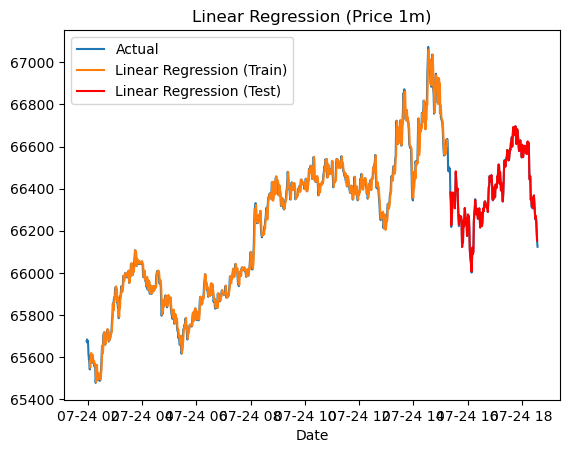

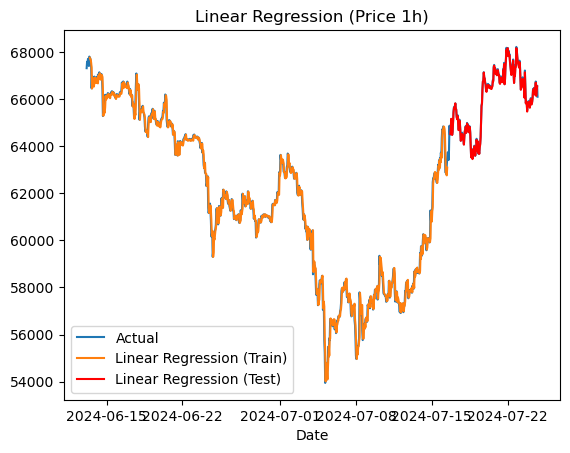

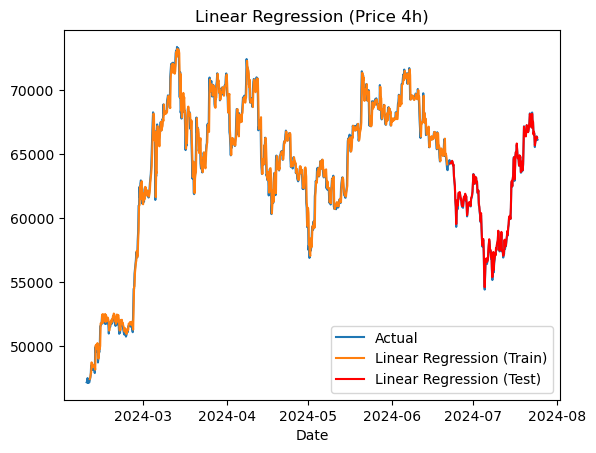

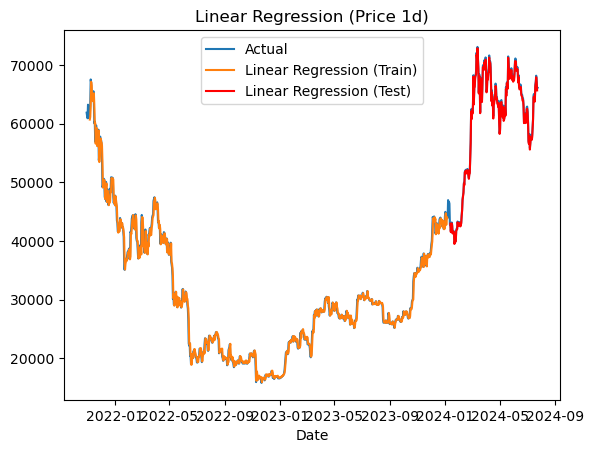

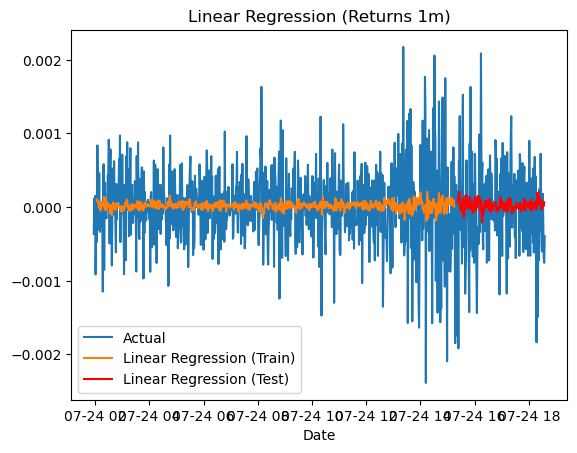

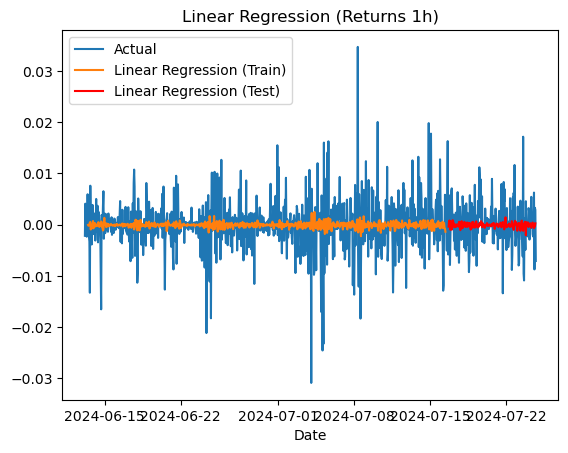

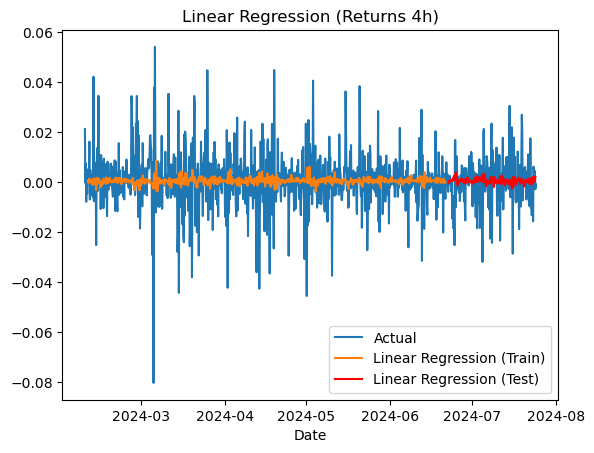

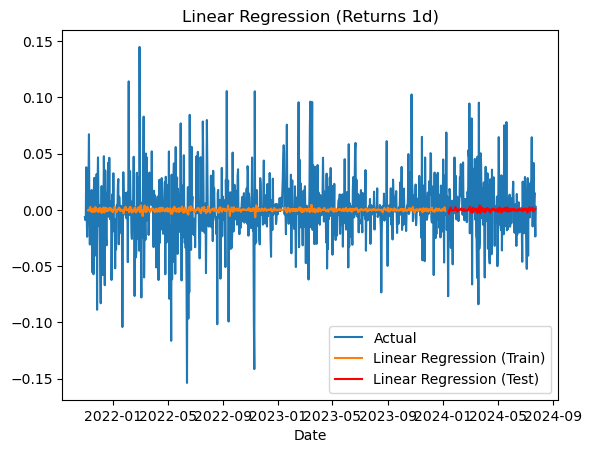

In [20]:
plot_forecast_result(lr_preds_train_1m_price, lr_preds_test_1m_price, df_1m['close'], 'Linear Regression (Price 1m)')
plot_forecast_result(lr_preds_train_1h_price, lr_preds_test_1h_price, df_1h['close'], 'Linear Regression (Price 1h)')
plot_forecast_result(lr_preds_train_4h_price, lr_preds_test_4h_price, df_4h['close'], 'Linear Regression (Price 4h)')
plot_forecast_result(lr_preds_train_1d_price, lr_preds_test_1d_price, df_1d['close'], 'Linear Regression (Price 1d)')

plot_forecast_result(lr_preds_train_1m_returns, lr_preds_test_1m_returns, df_1m['returns'], 'Linear Regression (Returns 1m)')
plot_forecast_result(lr_preds_train_1h_returns, lr_preds_test_1h_returns, df_1h['returns'], 'Linear Regression (Returns 1h)')
plot_forecast_result(lr_preds_train_4h_returns, lr_preds_test_4h_returns, df_4h['returns'], 'Linear Regression (Returns 4h)')
plot_forecast_result(lr_preds_train_1d_returns, lr_preds_test_1d_returns, df_1d['returns'], 'Linear Regression (Returns 1d)')

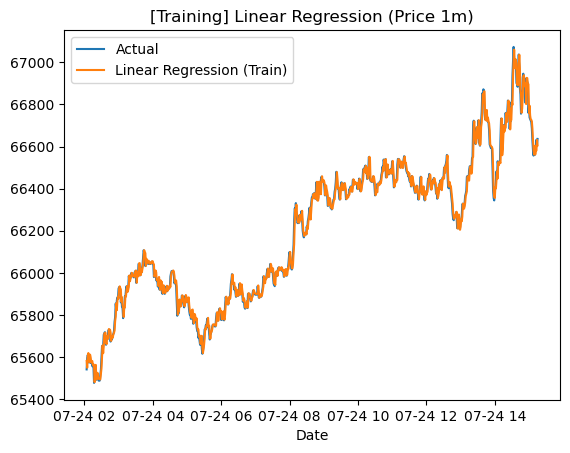

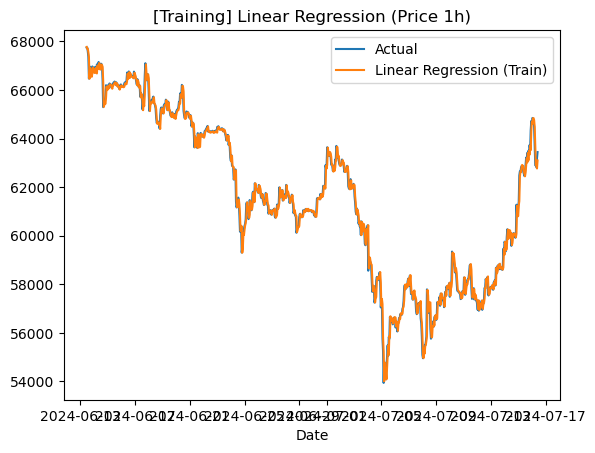

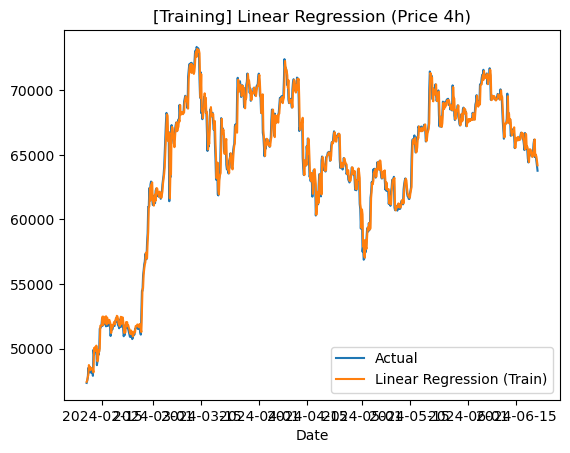

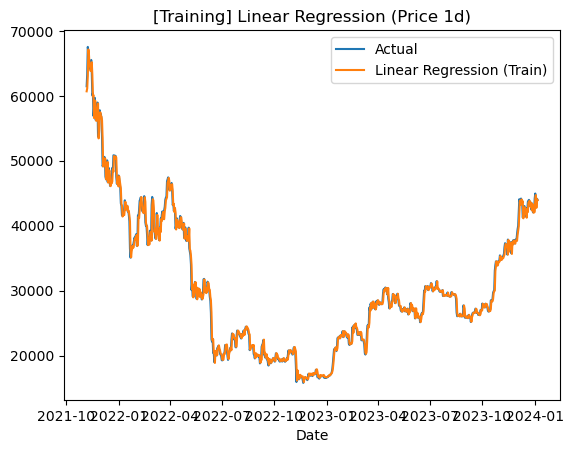

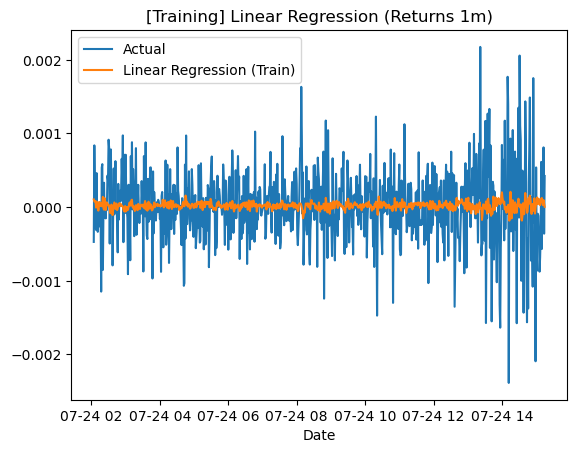

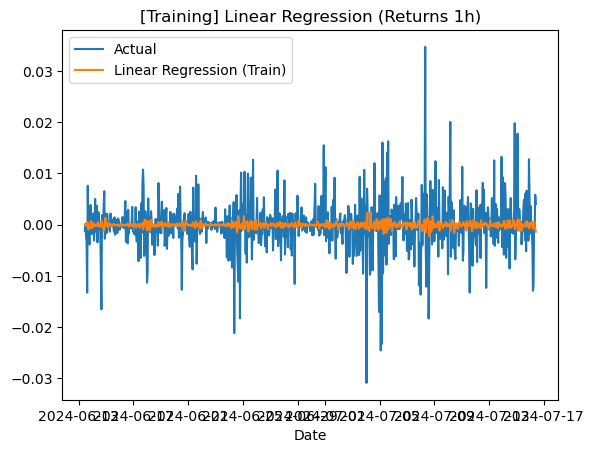

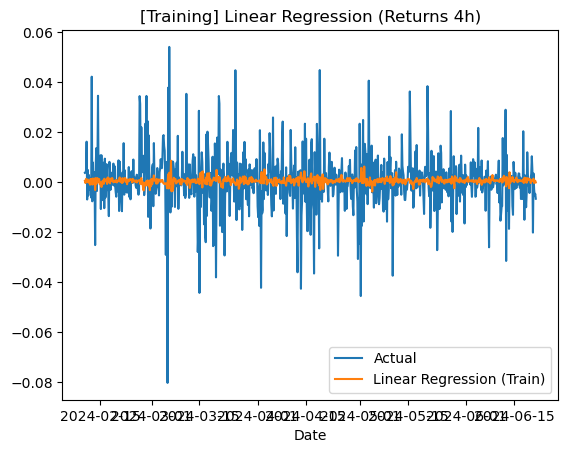

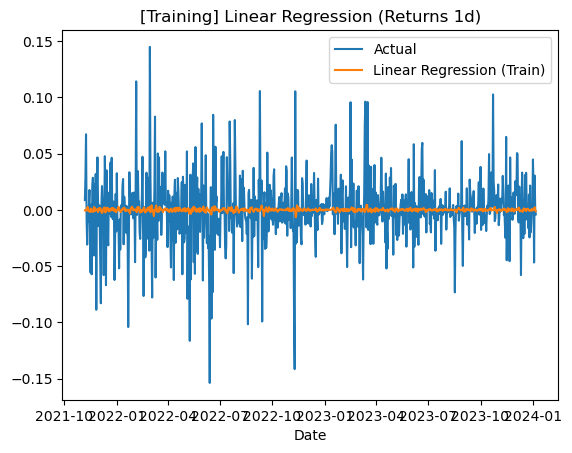

In [21]:
plot_forecast_result(lr_preds_train_1m_price, lr_preds_test_1m_price, df_1m['close'], 'Linear Regression (Price 1m)', 'train')
plot_forecast_result(lr_preds_train_1h_price, lr_preds_test_1h_price, df_1h['close'], 'Linear Regression (Price 1h)', 'train')
plot_forecast_result(lr_preds_train_4h_price, lr_preds_test_4h_price, df_4h['close'], 'Linear Regression (Price 4h)', 'train')
plot_forecast_result(lr_preds_train_1d_price, lr_preds_test_1d_price, df_1d['close'], 'Linear Regression (Price 1d)', 'train')

plot_forecast_result(lr_preds_train_1m_returns, lr_preds_test_1m_returns, df_1m['returns'], 'Linear Regression (Returns 1m)', 'train')
plot_forecast_result(lr_preds_train_1h_returns, lr_preds_test_1h_returns, df_1h['returns'], 'Linear Regression (Returns 1h)', 'train')
plot_forecast_result(lr_preds_train_4h_returns, lr_preds_test_4h_returns, df_4h['returns'], 'Linear Regression (Returns 4h)', 'train')
plot_forecast_result(lr_preds_train_1d_returns, lr_preds_test_1d_returns, df_1d['returns'], 'Linear Regression (Returns 1d)', 'train')

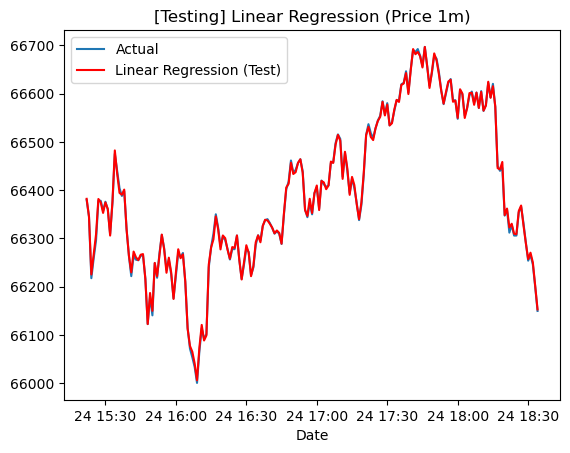

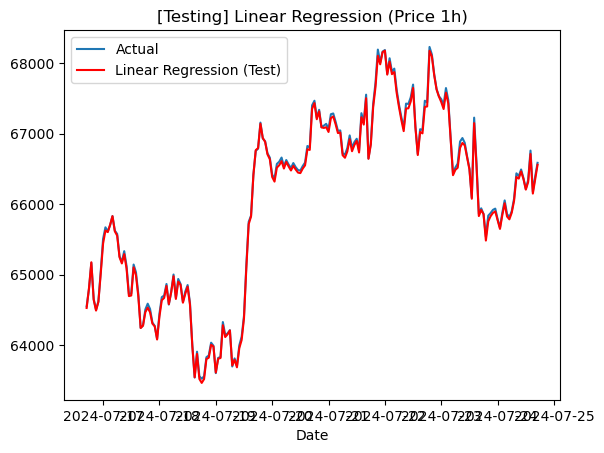

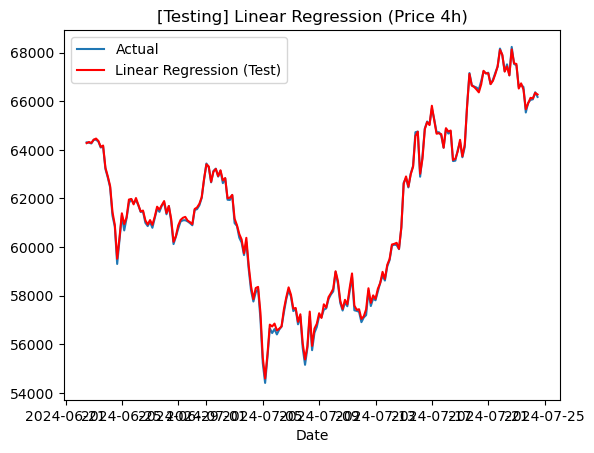

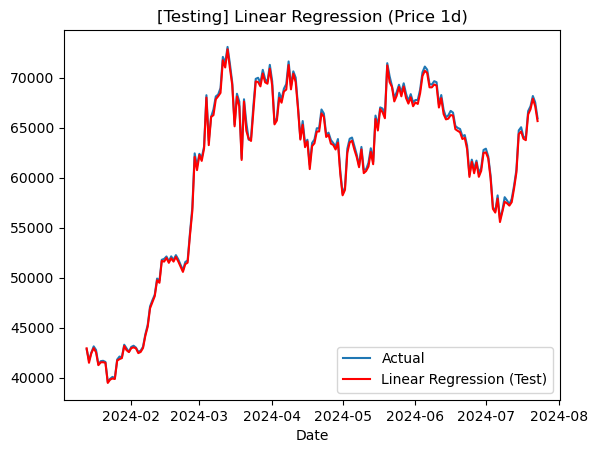

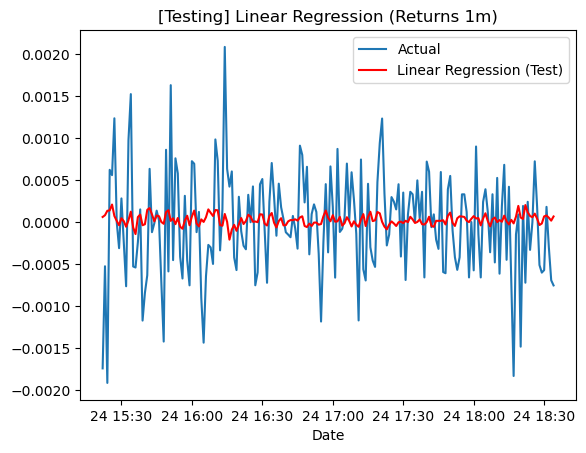

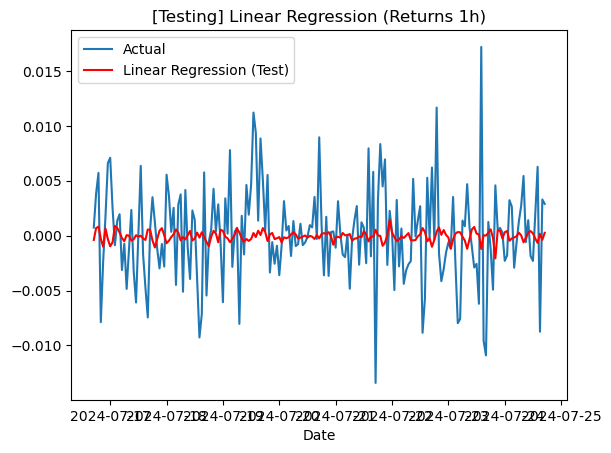

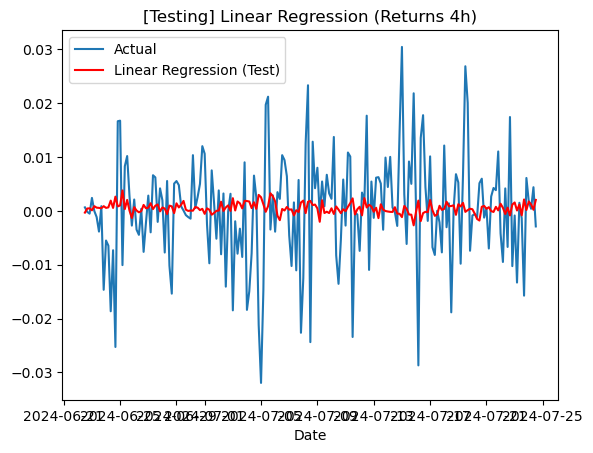

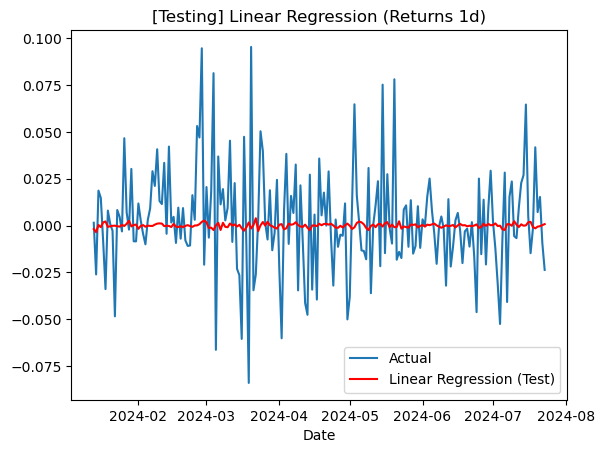

In [22]:
plot_forecast_result(lr_preds_train_1m_price, lr_preds_test_1m_price, df_1m['close'], 'Linear Regression (Price 1m)', 'test')
plot_forecast_result(lr_preds_train_1h_price, lr_preds_test_1h_price, df_1h['close'], 'Linear Regression (Price 1h)', 'test')
plot_forecast_result(lr_preds_train_4h_price, lr_preds_test_4h_price, df_4h['close'], 'Linear Regression (Price 4h)', 'test')
plot_forecast_result(lr_preds_train_1d_price, lr_preds_test_1d_price, df_1d['close'], 'Linear Regression (Price 1d)', 'test')

plot_forecast_result(lr_preds_train_1m_returns, lr_preds_test_1m_returns, df_1m['returns'], 'Linear Regression (Returns 1m)', 'test')
plot_forecast_result(lr_preds_train_1h_returns, lr_preds_test_1h_returns, df_1h['returns'], 'Linear Regression (Returns 1h)', 'test')
plot_forecast_result(lr_preds_train_4h_returns, lr_preds_test_4h_returns, df_4h['returns'], 'Linear Regression (Returns 4h)', 'test')
plot_forecast_result(lr_preds_train_1d_returns, lr_preds_test_1d_returns, df_1d['returns'], 'Linear Regression (Returns 1d)', 'test')

## CatBoost

In [23]:
from catboost import Pool, CatBoostRegressor

In [24]:
cb_train_pool_1m_price, cb_test_pool_1m_price = Pool(train_1m_price, train_label_1m_price), Pool(test_1m_price)
cb_train_pool_1h_price, cb_test_pool_1h_price = Pool(train_1h_price, train_label_1h_price), Pool(test_1h_price)
cb_train_pool_4h_price, cb_test_pool_4h_price = Pool(train_4h_price, train_label_4h_price), Pool(test_4h_price)
cb_train_pool_1d_price, cb_test_pool_1d_price = Pool(train_1d_price, train_label_1d_price), Pool(test_1d_price)

cb_train_pool_1m_returns, cb_test_pool_1m_returns = Pool(train_1m_returns, train_label_1m_returns), Pool(test_1m_returns)
cb_train_pool_1h_returns, cb_test_pool_1h_returns = Pool(train_1h_returns, train_label_1h_returns), Pool(test_1h_returns)
cb_train_pool_4h_returns, cb_test_pool_4h_returns = Pool(train_4h_returns, train_label_4h_returns), Pool(test_4h_returns)
cb_train_pool_1d_returns, cb_test_pool_1d_returns = Pool(train_1d_returns, train_label_1d_returns), Pool(test_1d_returns)

In [25]:
cb_model_1m_price = CatBoostRegressor()
cb_model_1m_price.fit(cb_train_pool_1m_price)

cb_model_1h_price = CatBoostRegressor()
cb_model_1h_price.fit(cb_train_pool_1h_price)

cb_model_4h_price = CatBoostRegressor()
cb_model_4h_price.fit(cb_train_pool_4h_price)

cb_model_1d_price = CatBoostRegressor()
cb_model_1d_price.fit(cb_train_pool_1d_price)

cb_model_1m_returns = CatBoostRegressor()
cb_model_1m_returns.fit(cb_train_pool_1m_returns)

cb_model_1h_returns = CatBoostRegressor()
cb_model_1h_returns.fit(cb_train_pool_1h_returns)

cb_model_4h_returns = CatBoostRegressor()
cb_model_4h_returns.fit(cb_train_pool_4h_returns)

cb_model_1d_returns = CatBoostRegressor()
cb_model_1d_returns.fit(cb_train_pool_1d_returns)

Learning rate set to 0.039462
0:	learn: 1.0133615	total: 57.2ms	remaining: 57.1s
1:	learn: 0.9778995	total: 58ms	remaining: 28.9s
2:	learn: 0.9439227	total: 58.7ms	remaining: 19.5s
3:	learn: 0.9102537	total: 59.4ms	remaining: 14.8s
4:	learn: 0.8785255	total: 60.2ms	remaining: 12s
5:	learn: 0.8479162	total: 60.9ms	remaining: 10.1s
6:	learn: 0.8183698	total: 61.6ms	remaining: 8.74s
7:	learn: 0.7900488	total: 62.3ms	remaining: 7.73s
8:	learn: 0.7626957	total: 63ms	remaining: 6.94s
9:	learn: 0.7357101	total: 63.7ms	remaining: 6.31s
10:	learn: 0.7105117	total: 64.4ms	remaining: 5.79s
11:	learn: 0.6862216	total: 65.1ms	remaining: 5.36s
12:	learn: 0.6625530	total: 65.8ms	remaining: 5s
13:	learn: 0.6401178	total: 66.5ms	remaining: 4.68s
14:	learn: 0.6182385	total: 67.2ms	remaining: 4.41s
15:	learn: 0.5975831	total: 67.9ms	remaining: 4.17s
16:	learn: 0.5778002	total: 68.6ms	remaining: 3.97s
17:	learn: 0.5587878	total: 69.4ms	remaining: 3.79s
18:	learn: 0.5405403	total: 70.1ms	remaining: 3.62s
1

In [26]:
cb_preds_train_1m_price = scaler_1m_price.inverse_transform(cb_model_1m_price.predict(cb_train_pool_1m_price).reshape(-1, 1))
cb_preds_train_1h_price = scaler_1h_price.inverse_transform(cb_model_1h_price.predict(cb_train_pool_1h_price).reshape(-1, 1))
cb_preds_train_4h_price = scaler_4h_price.inverse_transform(cb_model_4h_price.predict(cb_train_pool_4h_price).reshape(-1, 1))
cb_preds_train_1d_price = scaler_1d_price.inverse_transform(cb_model_1d_price.predict(cb_train_pool_1d_price).reshape(-1, 1))

cb_preds_test_1m_price = scaler_1m_price.inverse_transform(cb_model_1m_price.predict(cb_test_pool_1m_price).reshape(-1, 1))
cb_preds_test_1h_price = scaler_1h_price.inverse_transform(cb_model_1h_price.predict(cb_test_pool_1h_price).reshape(-1, 1))
cb_preds_test_4h_price = scaler_4h_price.inverse_transform(cb_model_4h_price.predict(cb_test_pool_4h_price).reshape(-1, 1))
cb_preds_test_1d_price = scaler_1d_price.inverse_transform(cb_model_1d_price.predict(cb_test_pool_1d_price).reshape(-1, 1))

cb_preds_train_1m_returns = scaler_1m_returns.inverse_transform(cb_model_1m_returns.predict(cb_train_pool_1m_returns).reshape(-1, 1))
cb_preds_train_1h_returns = scaler_1h_returns.inverse_transform(cb_model_1h_returns.predict(cb_train_pool_1h_returns).reshape(-1, 1))
cb_preds_train_4h_returns = scaler_4h_returns.inverse_transform(cb_model_4h_returns.predict(cb_train_pool_4h_returns).reshape(-1, 1))
cb_preds_train_1d_returns = scaler_1d_returns.inverse_transform(cb_model_1d_returns.predict(cb_train_pool_1d_returns).reshape(-1, 1))

cb_preds_test_1m_returns = scaler_1m_returns.inverse_transform(cb_model_1m_returns.predict(cb_test_pool_1m_returns).reshape(-1, 1))
cb_preds_test_1h_returns = scaler_1h_returns.inverse_transform(cb_model_1h_returns.predict(cb_test_pool_1h_returns).reshape(-1, 1))
cb_preds_test_4h_returns = scaler_4h_returns.inverse_transform(cb_model_4h_returns.predict(cb_test_pool_4h_returns).reshape(-1, 1))
cb_preds_test_1d_returns = scaler_1d_returns.inverse_transform(cb_model_1d_returns.predict(cb_test_pool_1d_returns).reshape(-1, 1))


In [27]:
print('***CatBoost Training Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(train_label_1m_price, cb_preds_train_1m_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1m_price, cb_preds_train_1m_price):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(train_label_1h_price, cb_preds_train_1h_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1h_price, cb_preds_train_1h_price):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(train_label_4h_price, cb_preds_train_4h_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_4h_price, cb_preds_train_4h_price):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(train_label_1d_price, cb_preds_train_1d_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1d_price, cb_preds_train_1d_price):.4f}')

***CatBoost Training Evaluation (Price)***
---1 Minute---
R²: -3970475969.8656
MSE: 4382703564.2629
---1 Hour---
R²: -4239831631.3019
MSE: 3801986091.5238
---4 Hours---
R²: -3964831626.4052
MSE: 4183038649.9037
---1 Days---
R²: -2358380063.6847
MSE: 1038512093.5914


In [28]:
print('***CatBoost Testing Evaluation*** (Price)')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(test_label_1m_price, cb_preds_test_1m_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1m_price, cb_preds_test_1m_price):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(test_label_1h_price, cb_preds_test_1h_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1h_price, cb_preds_test_1h_price):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(test_label_4h_price, cb_preds_test_4h_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_4h_price, cb_preds_test_4h_price):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(test_label_1d_price, cb_preds_test_1d_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1d_price, cb_preds_test_1d_price):.4f}')

***CatBoost Testing Evaluation*** (Price)
---1 Minute---
R²: -18924512892.8826
MSE: 4409411224.6965
---1 Hour---
R²: -33912059077.5623
MSE: 4338791367.4720
---4 Hours---
R²: -10721731315.6389
MSE: 3842058230.5245
---1 Days---
R²: -10481042325.2603
MSE: 3446970305.8372


In [29]:
print('***CatBoost Training Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(train_label_1m_returns, cb_preds_train_1m_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1m_returns, cb_preds_train_1m_returns):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(train_label_1h_returns, cb_preds_train_1h_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1h_returns, cb_preds_train_1h_returns):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(train_label_4h_returns, cb_preds_train_4h_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_4h_returns, cb_preds_train_4h_returns):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(train_label_1d_returns, cb_preds_train_1d_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1d_returns, cb_preds_train_1d_returns):.4f}')

***CatBoost Training Evaluation (Returns)***
---1 Minute---
R²: 0.0001
MSE: 0.8949
---1 Hour---
R²: 0.0072
MSE: 1.0368
---4 Hours---
R²: 0.0167
MSE: 1.0415
---1 Days---
R²: 0.0421
MSE: 0.9733


In [30]:
print('***CatBoost Testing Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(test_label_1m_returns, cb_preds_test_1m_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1m_returns, cb_preds_test_1m_returns):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(test_label_1h_returns, cb_preds_test_1h_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1h_returns, cb_preds_test_1h_returns):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(test_label_4h_returns, cb_preds_test_4h_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_4h_returns, cb_preds_test_4h_returns):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(test_label_1d_returns, cb_preds_test_1d_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1d_returns, cb_preds_test_1d_returns):.4f}')

***CatBoost Testing Evaluation (Returns)***
---1 Minute---
R²: -0.0018
MSE: 1.3446
---1 Hour---
R²: -0.0008
MSE: 0.7892
---4 Hours---
R²: -0.0012
MSE: 0.7996
---1 Days---
R²: -0.0068
MSE: 0.9224


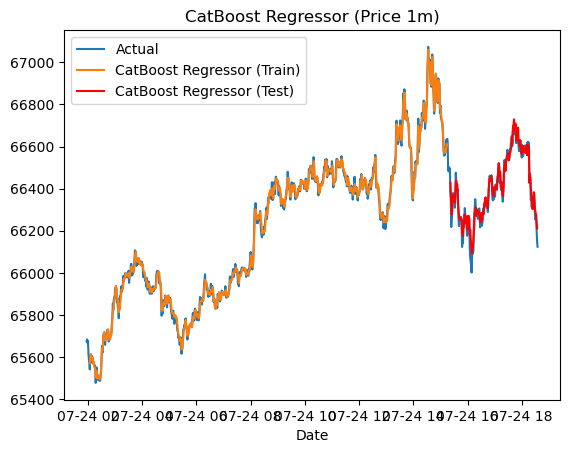

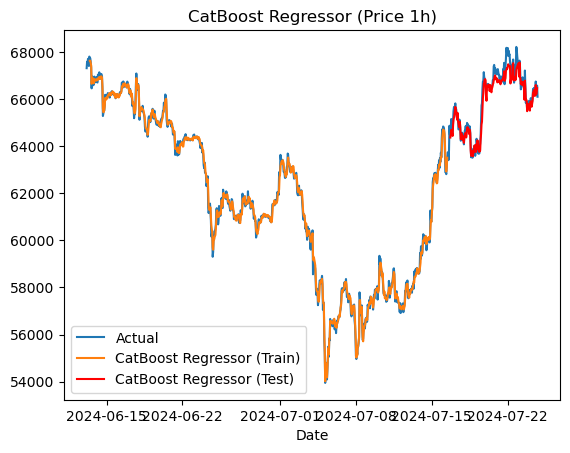

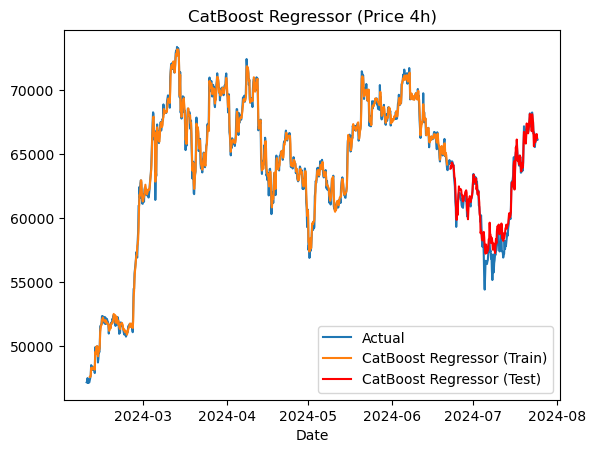

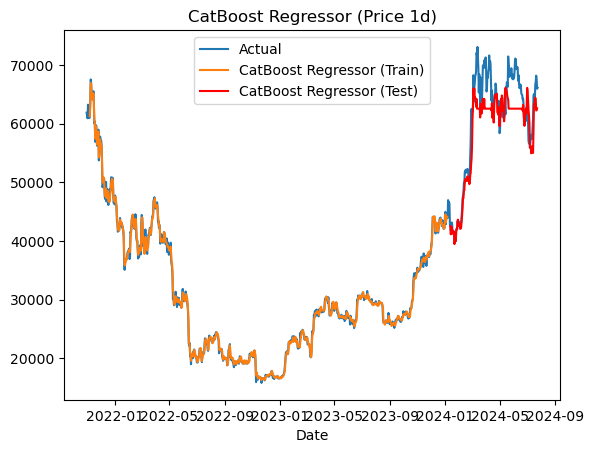

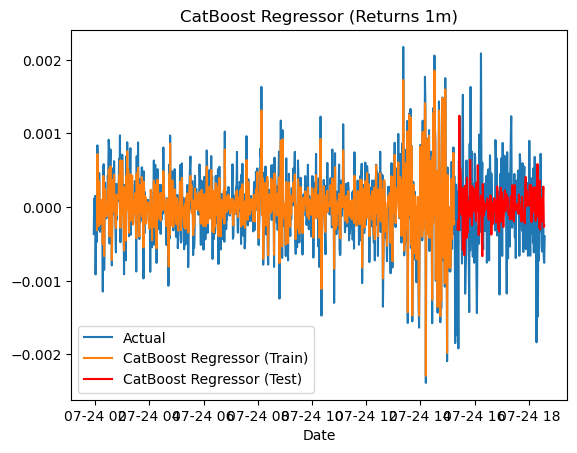

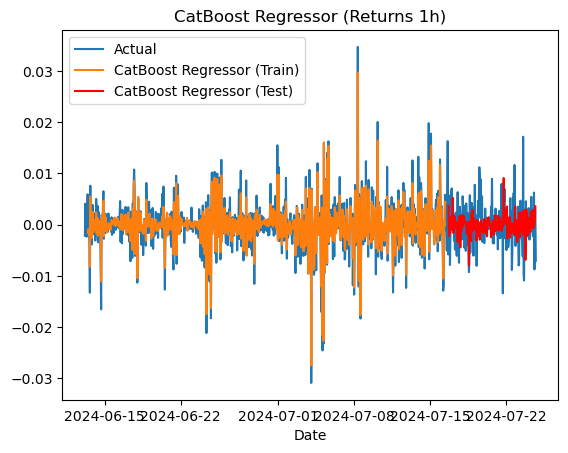

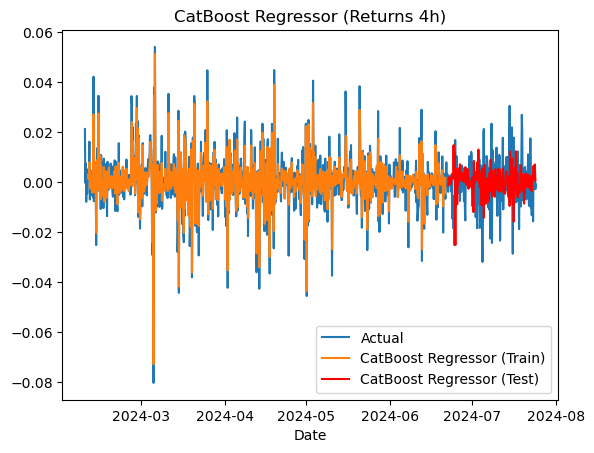

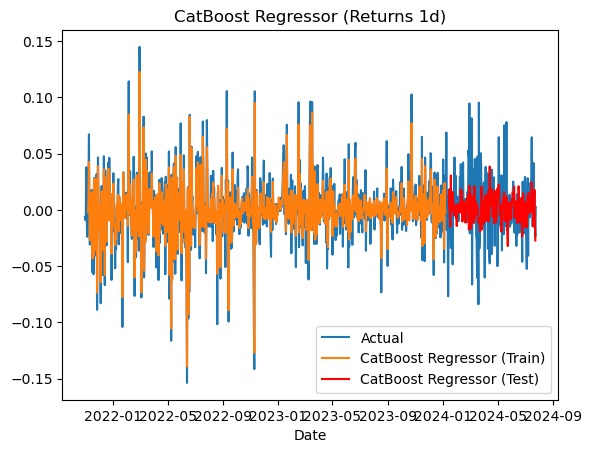

In [31]:
plot_forecast_result(cb_preds_train_1m_price, cb_preds_test_1m_price, df_1m['close'], 'CatBoost Regressor (Price 1m)')
plot_forecast_result(cb_preds_train_1h_price, cb_preds_test_1h_price, df_1h['close'], 'CatBoost Regressor (Price 1h)')
plot_forecast_result(cb_preds_train_4h_price, cb_preds_test_4h_price, df_4h['close'], 'CatBoost Regressor (Price 4h)')
plot_forecast_result(cb_preds_train_1d_price, cb_preds_test_1d_price, df_1d['close'], 'CatBoost Regressor (Price 1d)')

plot_forecast_result(cb_preds_train_1m_returns, cb_preds_test_1m_returns, df_1m['returns'], 'CatBoost Regressor (Returns 1m)')
plot_forecast_result(cb_preds_train_1h_returns, cb_preds_test_1h_returns, df_1h['returns'], 'CatBoost Regressor (Returns 1h)')
plot_forecast_result(cb_preds_train_4h_returns, cb_preds_test_4h_returns, df_4h['returns'], 'CatBoost Regressor (Returns 4h)')
plot_forecast_result(cb_preds_train_1d_returns, cb_preds_test_1d_returns, df_1d['returns'], 'CatBoost Regressor (Returns 1d)')

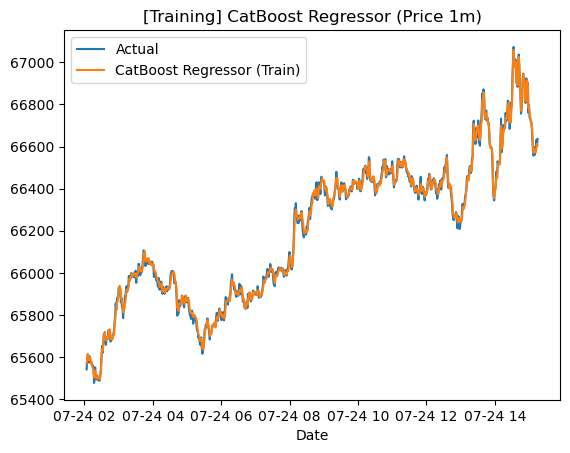

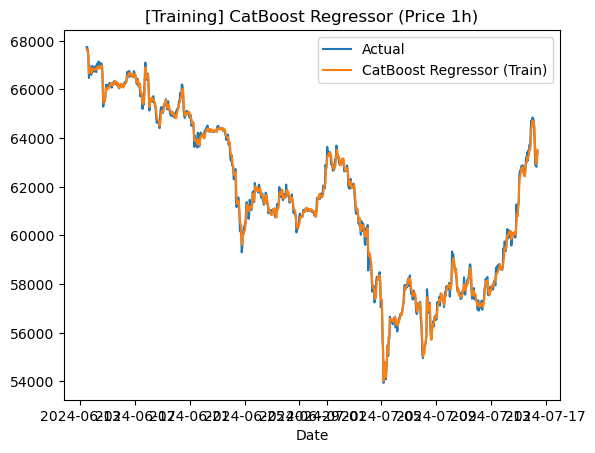

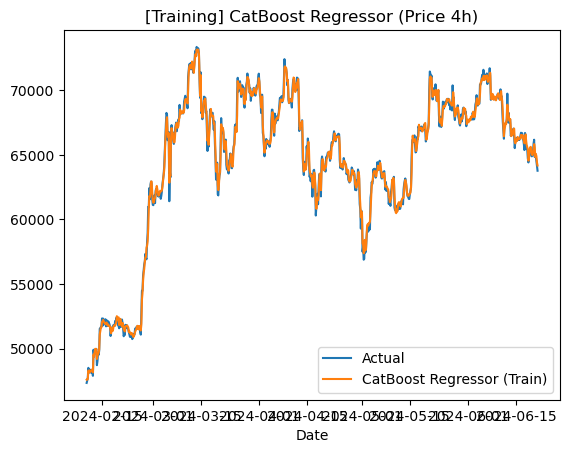

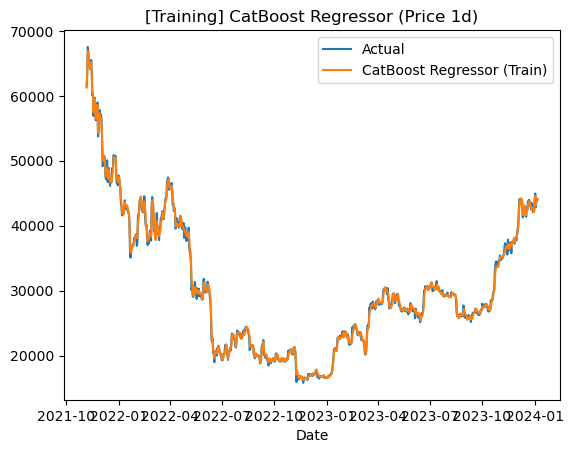

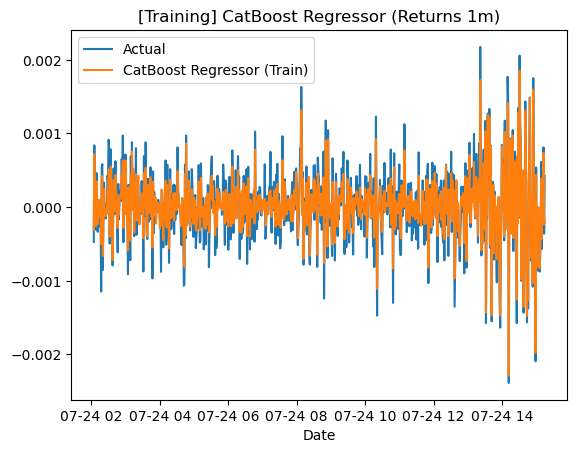

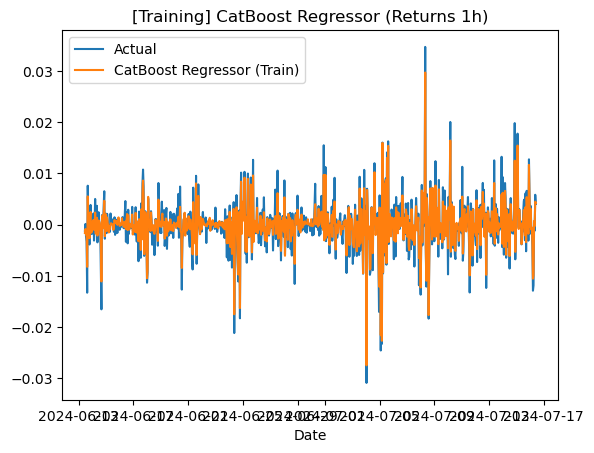

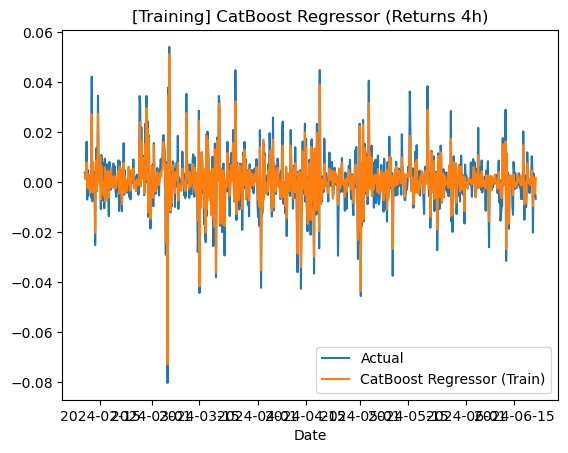

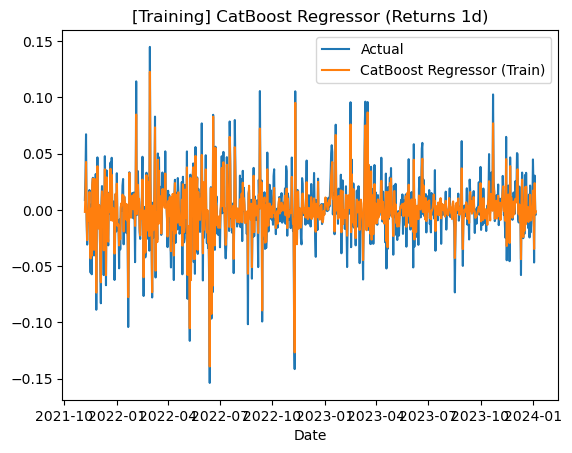

In [32]:
plot_forecast_result(cb_preds_train_1m_price, cb_preds_test_1m_price, df_1m['close'], 'CatBoost Regressor (Price 1m)', 'train')
plot_forecast_result(cb_preds_train_1h_price, cb_preds_test_1h_price, df_1h['close'], 'CatBoost Regressor (Price 1h)', 'train')
plot_forecast_result(cb_preds_train_4h_price, cb_preds_test_4h_price, df_4h['close'], 'CatBoost Regressor (Price 4h)', 'train')
plot_forecast_result(cb_preds_train_1d_price, cb_preds_test_1d_price, df_1d['close'], 'CatBoost Regressor (Price 1d)', 'train')

plot_forecast_result(cb_preds_train_1m_returns, cb_preds_test_1m_returns, df_1m['returns'], 'CatBoost Regressor (Returns 1m)', 'train')
plot_forecast_result(cb_preds_train_1h_returns, cb_preds_test_1h_returns, df_1h['returns'], 'CatBoost Regressor (Returns 1h)', 'train')
plot_forecast_result(cb_preds_train_4h_returns, cb_preds_test_4h_returns, df_4h['returns'], 'CatBoost Regressor (Returns 4h)', 'train')
plot_forecast_result(cb_preds_train_1d_returns, cb_preds_test_1d_returns, df_1d['returns'], 'CatBoost Regressor (Returns 1d)', 'train')

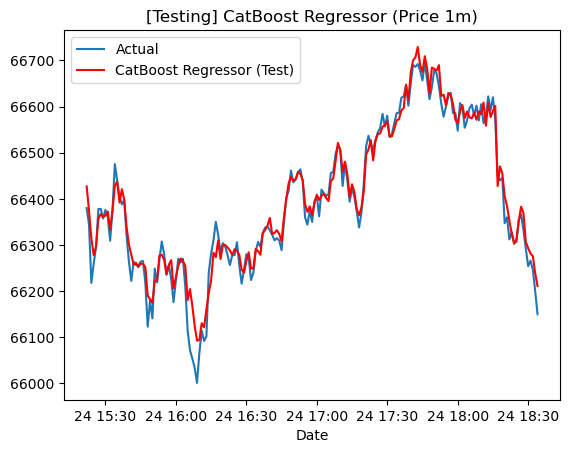

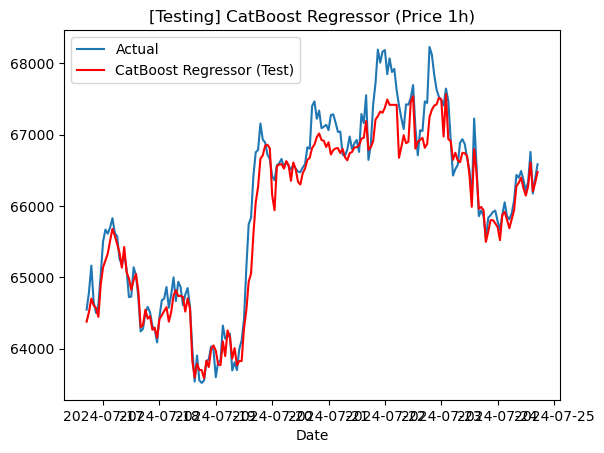

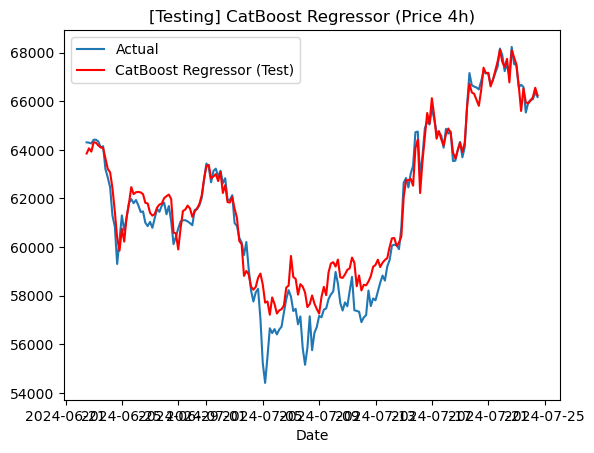

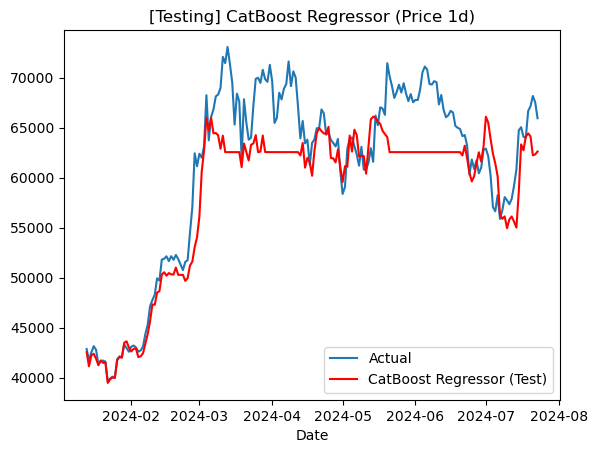

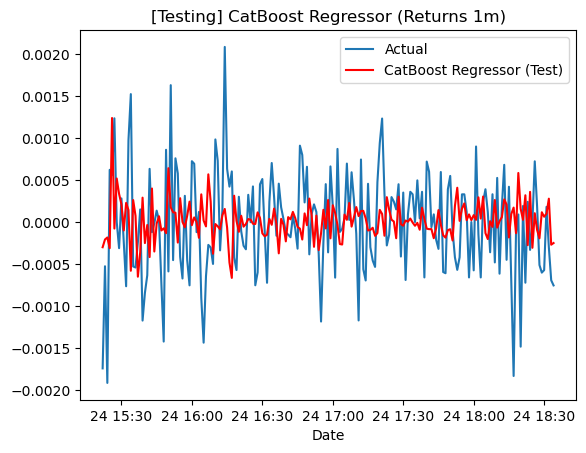

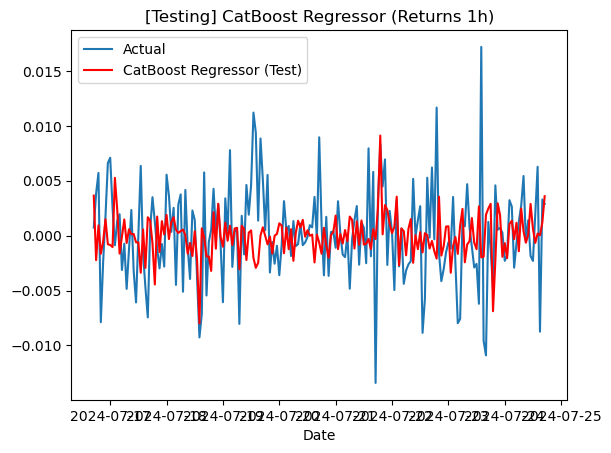

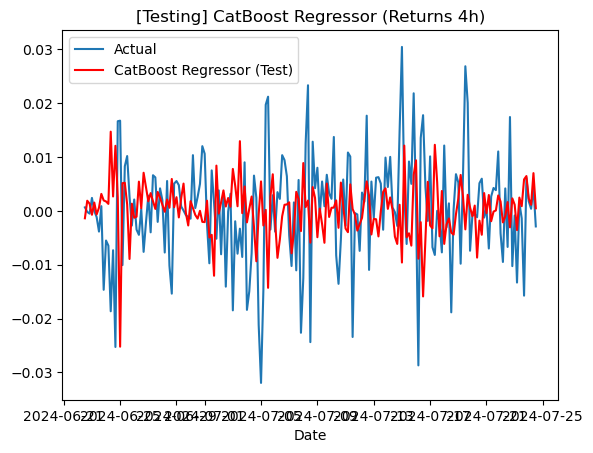

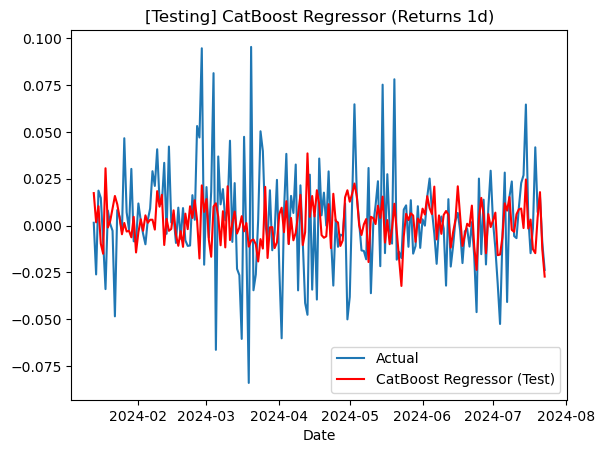

In [33]:
plot_forecast_result(cb_preds_train_1m_price, cb_preds_test_1m_price, df_1m['close'], 'CatBoost Regressor (Price 1m)', 'test')
plot_forecast_result(cb_preds_train_1h_price, cb_preds_test_1h_price, df_1h['close'], 'CatBoost Regressor (Price 1h)', 'test')
plot_forecast_result(cb_preds_train_4h_price, cb_preds_test_4h_price, df_4h['close'], 'CatBoost Regressor (Price 4h)', 'test')
plot_forecast_result(cb_preds_train_1d_price, cb_preds_test_1d_price, df_1d['close'], 'CatBoost Regressor (Price 1d)', 'test')

plot_forecast_result(cb_preds_train_1m_returns, cb_preds_test_1m_returns, df_1m['returns'], 'CatBoost Regressor (Returns 1m)', 'test')
plot_forecast_result(cb_preds_train_1h_returns, cb_preds_test_1h_returns, df_1h['returns'], 'CatBoost Regressor (Returns 1h)', 'test')
plot_forecast_result(cb_preds_train_4h_returns, cb_preds_test_4h_returns, df_4h['returns'], 'CatBoost Regressor (Returns 4h)', 'test')
plot_forecast_result(cb_preds_train_1d_returns, cb_preds_test_1d_returns, df_1d['returns'], 'CatBoost Regressor (Returns 1d)', 'test')

## LSTM

In [34]:
import keras
from sklearn.preprocessing import StandardScaler

In [59]:
class lstmModel():
    def __init__(self, window_size):
        self.window_size = window_size

    def build_model(self):
        lstm_model = keras.Sequential()
        lstm_model.add(keras.layers.InputLayer((self.window_size, 1)))
        lstm_model.add(keras.layers.LSTM(128, return_sequences=True))
        lstm_model.add(keras.layers.Dropout(0.2))
        lstm_model.add(keras.layers.LSTM(64))
        lstm_model.add(keras.layers.Dropout(0.2))
        lstm_model.add(keras.layers.Dense(32, activation='relu'))
        lstm_model.add(keras.layers.Dense(1, activation='linear'))

        lstm_model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.0001))

        return lstm_model

In [66]:
lstm_model_1m_price = lstmModel(window_size).build_model()
lstm_model_1h_price = lstmModel(window_size).build_model()
lstm_model_4h_price = lstmModel(window_size).build_model()
lstm_model_1d_price = lstmModel(window_size).build_model()

lstm_model_1m_returns = lstmModel(window_size).build_model()
lstm_model_1h_returns = lstmModel(window_size).build_model()
lstm_model_4h_returns = lstmModel(window_size).build_model()
lstm_model_1d_returns = lstmModel(window_size).build_model()

In [67]:
lstm_model_1m_price.fit(train_1m_price, train_label_1m_price, epochs=lstm_epochs)
lstm_model_1h_price.fit(train_1h_price, train_label_1h_price, epochs=lstm_epochs)
lstm_model_4h_price.fit(train_4h_price, train_label_4h_price, epochs=lstm_epochs)
lstm_model_1d_price.fit(train_1d_price, train_label_1d_price, epochs=lstm_epochs)

lstm_model_1m_returns.fit(train_1m_returns, train_label_1m_returns, epochs=lstm_epochs)
lstm_model_1h_returns.fit(train_1h_returns, train_label_1h_returns, epochs=lstm_epochs)
lstm_model_4h_returns.fit(train_4h_returns, train_label_4h_returns, epochs=lstm_epochs)
lstm_model_1d_returns.fit(train_1d_returns, train_label_1d_returns, epochs=lstm_epochs)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0297
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8615
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6318
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4861
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3496
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1880
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0734
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0663
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0551
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0562
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0530
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0459
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0523
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0502
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0576
Epoch 16/20
25/

In [68]:
lstm_preds_train_1m_price = scaler_1m_price.inverse_transform(lstm_model_1m_price.predict(train_1m_price))
lstm_preds_train_1h_price = scaler_1h_price.inverse_transform(lstm_model_1h_price.predict(train_1h_price))
lstm_preds_train_4h_price = scaler_4h_price.inverse_transform(lstm_model_4h_price.predict(train_4h_price))
lstm_preds_train_1d_price = scaler_1d_price.inverse_transform(lstm_model_1d_price.predict(train_1d_price))

lstm_preds_test_1m_price = scaler_1m_price.inverse_transform(lstm_model_1m_price.predict(test_1m_price))
lstm_preds_test_1h_price = scaler_1h_price.inverse_transform(lstm_model_1h_price.predict(test_1h_price))
lstm_preds_test_4h_price = scaler_4h_price.inverse_transform(lstm_model_4h_price.predict(test_4h_price))
lstm_preds_test_1d_price = scaler_1d_price.inverse_transform(lstm_model_1d_price.predict(test_1d_price))

lstm_preds_train_1m_returns = scaler_1m_returns.inverse_transform(lstm_model_1m_returns.predict(train_1m_returns))
lstm_preds_train_1h_returns = scaler_1h_returns.inverse_transform(lstm_model_1h_returns.predict(train_1h_returns))
lstm_preds_train_4h_returns = scaler_4h_returns.inverse_transform(lstm_model_4h_returns.predict(train_4h_returns))
lstm_preds_train_1d_returns = scaler_1d_returns.inverse_transform(lstm_model_1d_returns.predict(train_1d_returns))

lstm_preds_test_1m_returns = scaler_1m_returns.inverse_transform(lstm_model_1m_returns.predict(test_1m_returns))
lstm_preds_test_1h_returns = scaler_1h_returns.inverse_transform(lstm_model_1h_returns.predict(test_1h_returns))
lstm_preds_test_4h_returns = scaler_4h_returns.inverse_transform(lstm_model_4h_returns.predict(test_4h_returns))
lstm_preds_test_1d_returns = scaler_1d_returns.inverse_transform(lstm_model_1d_returns.predict(test_1d_returns))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [69]:
print('***LSTM Training Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(train_label_1m_price, lstm_preds_train_1m_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1m_price, lstm_preds_train_1m_price):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(train_label_1h_price, lstm_preds_train_1h_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1h_price, lstm_preds_train_1h_price):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(train_label_4h_price, lstm_preds_train_4h_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_4h_price, lstm_preds_train_4h_price):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(train_label_1d_price, lstm_preds_train_1d_price):.4f}')
print(f'MSE: {mean_squared_error(train_label_1d_price, lstm_preds_train_1d_price):.4f}')

***LSTM Training Evaluation (Price)***
---1 Minute---
R²: -3970145921.5226
MSE: 4382339249.2388
---1 Hour---
R²: -4241304823.0518
MSE: 3803307147.4121
---4 Hours---
R²: -3961604503.8367
MSE: 4179633920.5986
---1 Days---
R²: -2379299963.3630
MSE: 1047724166.3773


In [70]:
print('***LSTM Testing Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(test_label_1m_price, lstm_preds_test_1m_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1m_price, lstm_preds_test_1m_price):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(test_label_1h_price, lstm_preds_test_1h_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1h_price, lstm_preds_test_1h_price):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(test_label_4h_price, lstm_preds_test_4h_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_4h_price, lstm_preds_test_4h_price):.4f}')
print('---1 Day---')
print(f'R\u00b2: {r2_score(test_label_1d_price, lstm_preds_test_1d_price):.4f}')
print(f'MSE: {mean_squared_error(test_label_1d_price, lstm_preds_test_1d_price):.4f}')

***LSTM Testing Evaluation (Price)***
---1 Minute---
R²: -18922685336.4311
MSE: 4408985404.0703
---1 Hour---
R²: -33913554863.9474
MSE: 4338982742.0222
---4 Hours---
R²: -10723393369.8955
MSE: 3842653816.1671
---1 Day---
R²: -10594918877.5936
MSE: 3484421647.2406


In [71]:
print('***LSTM Training Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(train_label_1m_returns, lstm_preds_train_1m_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1m_returns, lstm_preds_train_1m_returns):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(train_label_1h_returns, lstm_preds_train_1h_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1h_returns, lstm_preds_train_1h_returns):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(train_label_4h_returns, lstm_preds_train_4h_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_4h_returns, lstm_preds_train_4h_returns):.4f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(train_label_1d_returns, lstm_preds_train_1d_returns):.4f}')
print(f'MSE: {mean_squared_error(train_label_1d_returns, lstm_preds_train_1d_returns):.4f}')

***LSTM Training Evaluation (Returns)***
---1 Minute---
R²: -0.0007
MSE: 0.8956
---1 Hour---
R²: -0.0001
MSE: 1.0445
---4 Hours---
R²: 0.0001
MSE: 1.0590
---1 Days---
R²: -0.0002
MSE: 1.0163


In [72]:
print('***LSTM Testing Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(test_label_1m_returns, lstm_preds_test_1m_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1m_returns, lstm_preds_test_1m_returns):.4f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(test_label_1h_returns, lstm_preds_test_1h_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1h_returns, lstm_preds_test_1h_returns):.4f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(test_label_4h_returns, lstm_preds_test_4h_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_4h_returns, lstm_preds_test_4h_returns):.4f}')
print('---1 Day---')
print(f'R\u00b2: {r2_score(test_label_1d_returns, lstm_preds_test_1d_returns):.4f}')
print(f'MSE: {mean_squared_error(test_label_1d_returns, lstm_preds_test_1d_returns):.4f}')

***LSTM Testing Evaluation (Returns)***
---1 Minute---
R²: -0.0019
MSE: 1.3447
---1 Hour---
R²: -0.0011
MSE: 0.7895
---4 Hours---
R²: -0.0007
MSE: 0.7991
---1 Day---
R²: -0.0061
MSE: 0.9218


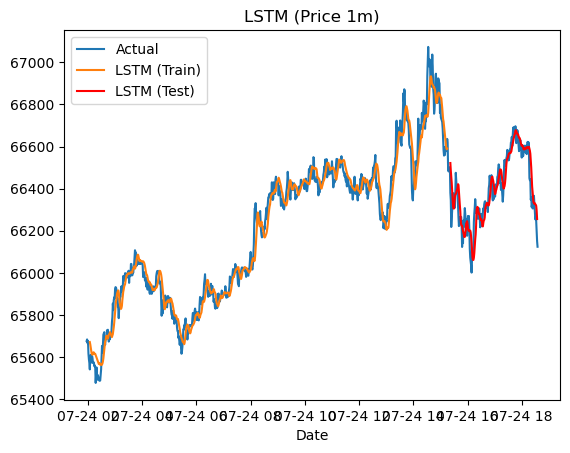

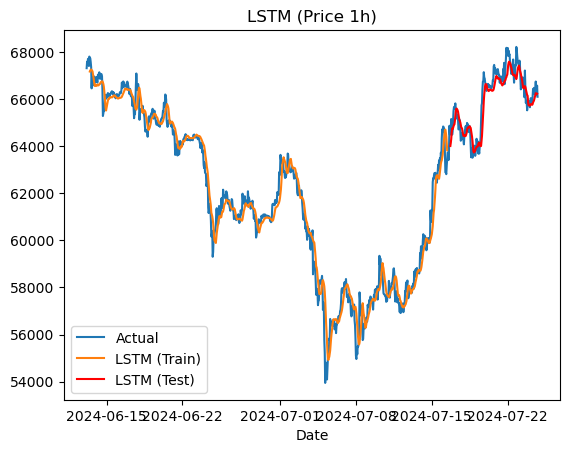

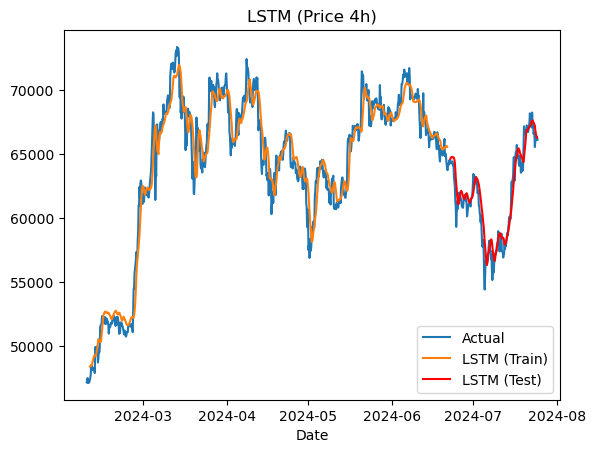

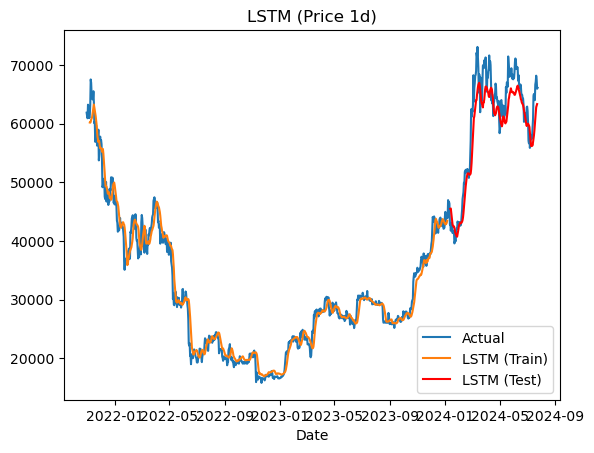

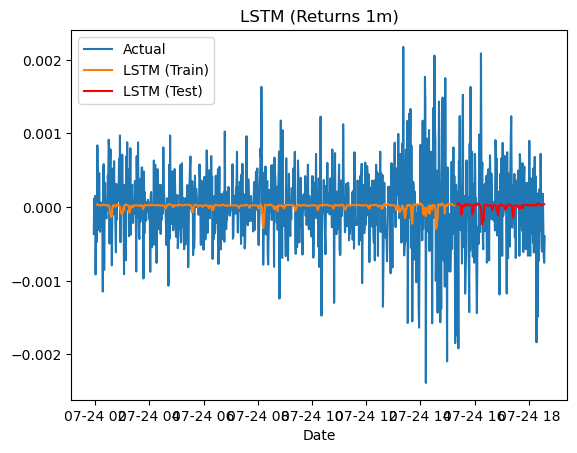

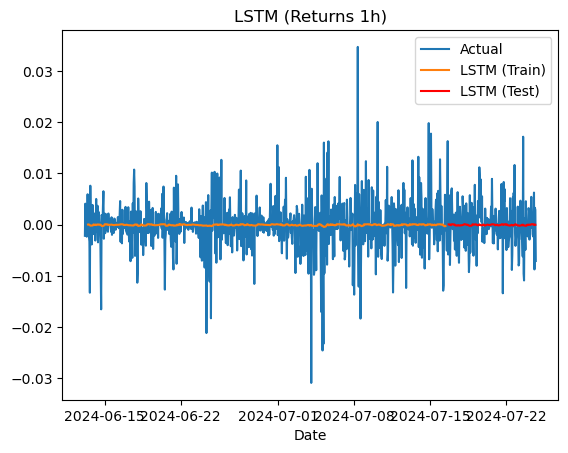

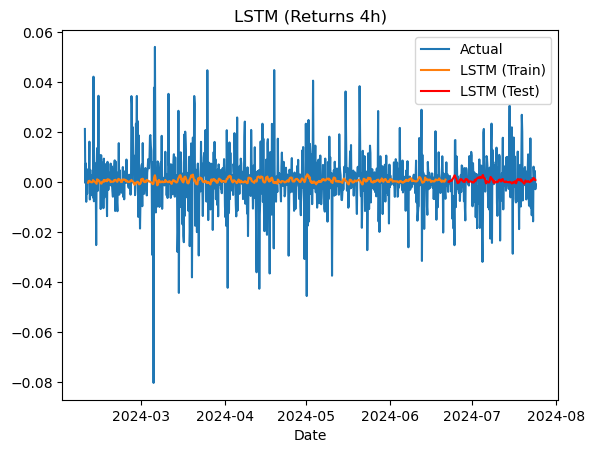

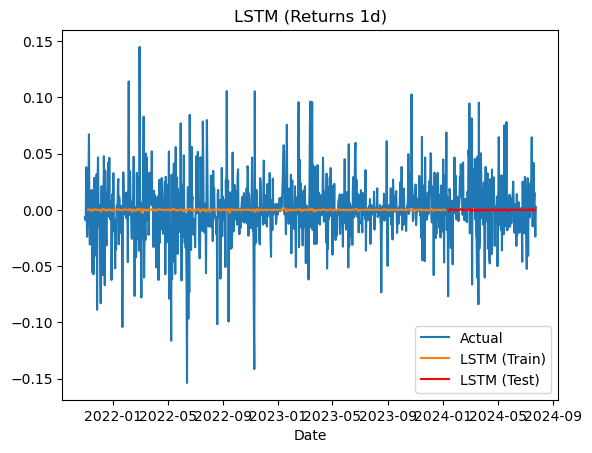

In [73]:
plot_forecast_result(lstm_preds_train_1m_price, lstm_preds_test_1m_price, df_1m['close'], 'LSTM (Price 1m)')
plot_forecast_result(lstm_preds_train_1h_price, lstm_preds_test_1h_price, df_1h['close'], 'LSTM (Price 1h)')
plot_forecast_result(lstm_preds_train_4h_price, lstm_preds_test_4h_price, df_4h['close'], 'LSTM (Price 4h)')
plot_forecast_result(lstm_preds_train_1d_price, lstm_preds_test_1d_price, df_1d['close'], 'LSTM (Price 1d)')

plot_forecast_result(lstm_preds_train_1m_returns, lstm_preds_test_1m_returns, df_1m['returns'], 'LSTM (Returns 1m)')
plot_forecast_result(lstm_preds_train_1h_returns, lstm_preds_test_1h_returns, df_1h['returns'], 'LSTM (Returns 1h)')
plot_forecast_result(lstm_preds_train_4h_returns, lstm_preds_test_4h_returns, df_4h['returns'], 'LSTM (Returns 4h)')
plot_forecast_result(lstm_preds_train_1d_returns, lstm_preds_test_1d_returns, df_1d['returns'], 'LSTM (Returns 1d)')

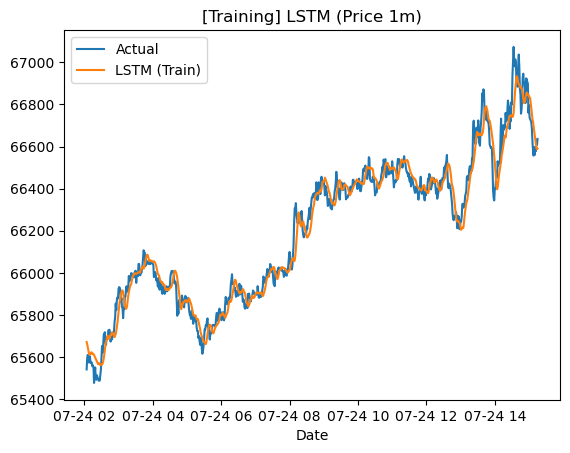

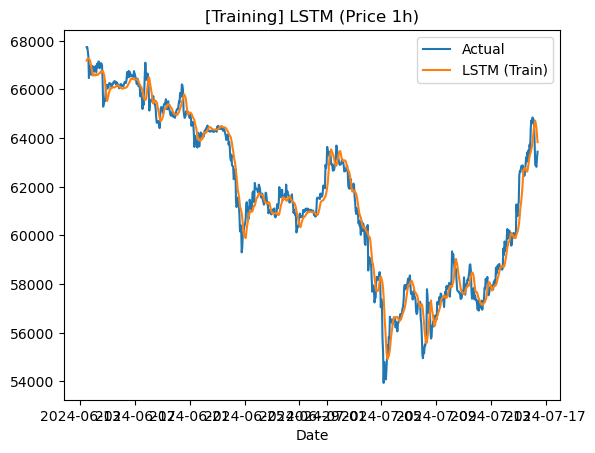

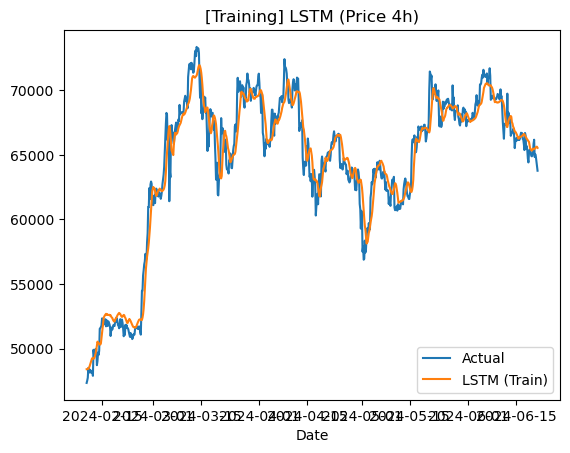

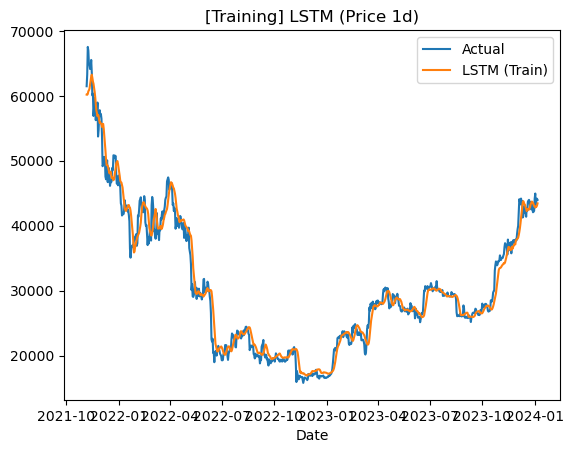

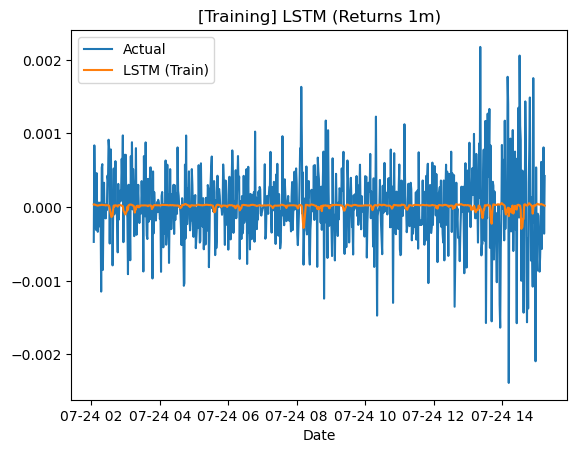

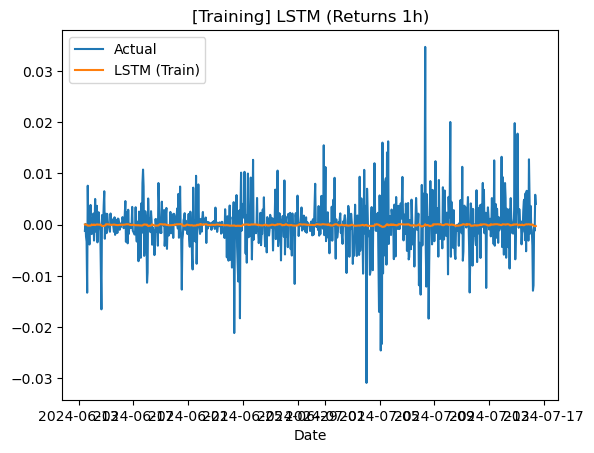

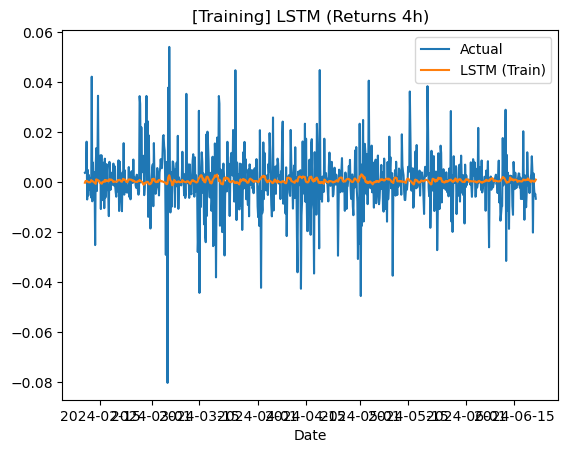

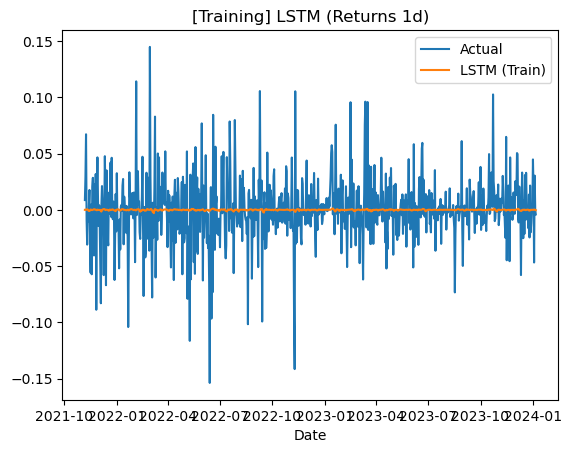

In [74]:
plot_forecast_result(lstm_preds_train_1m_price, lstm_preds_test_1m_price, df_1m['close'], 'LSTM (Price 1m)', 'train')
plot_forecast_result(lstm_preds_train_1h_price, lstm_preds_test_1h_price, df_1h['close'], 'LSTM (Price 1h)', 'train')
plot_forecast_result(lstm_preds_train_4h_price, lstm_preds_test_4h_price, df_4h['close'], 'LSTM (Price 4h)', 'train')
plot_forecast_result(lstm_preds_train_1d_price, lstm_preds_test_1d_price, df_1d['close'], 'LSTM (Price 1d)', 'train')

plot_forecast_result(lstm_preds_train_1m_returns, lstm_preds_test_1m_returns, df_1m['returns'], 'LSTM (Returns 1m)', 'train')
plot_forecast_result(lstm_preds_train_1h_returns, lstm_preds_test_1h_returns, df_1h['returns'], 'LSTM (Returns 1h)', 'train')
plot_forecast_result(lstm_preds_train_4h_returns, lstm_preds_test_4h_returns, df_4h['returns'], 'LSTM (Returns 4h)', 'train')
plot_forecast_result(lstm_preds_train_1d_returns, lstm_preds_test_1d_returns, df_1d['returns'], 'LSTM (Returns 1d)', 'train')

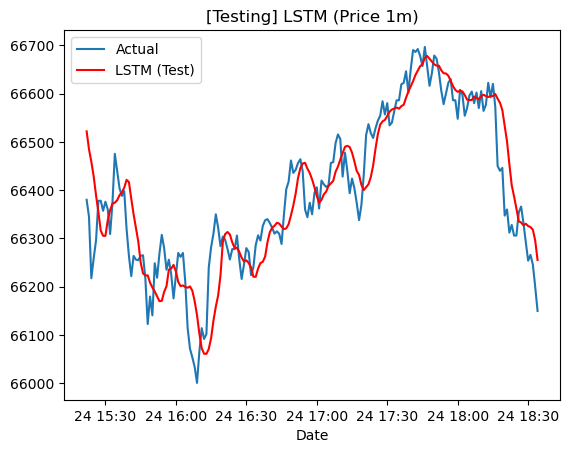

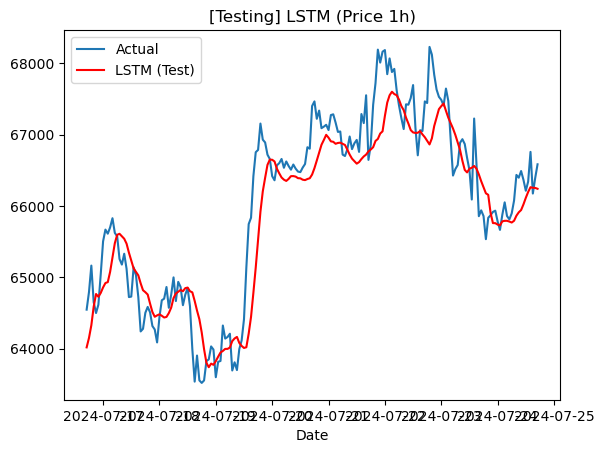

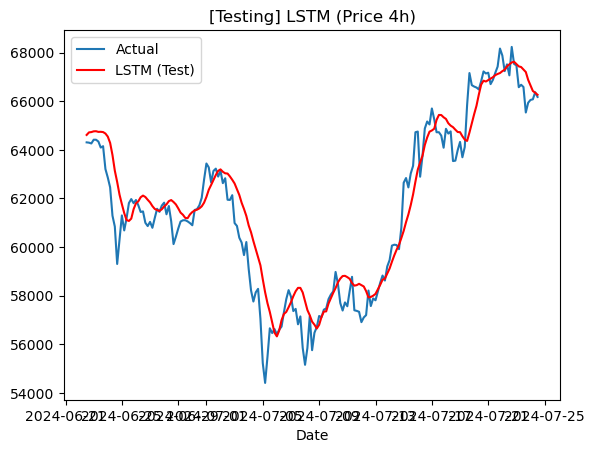

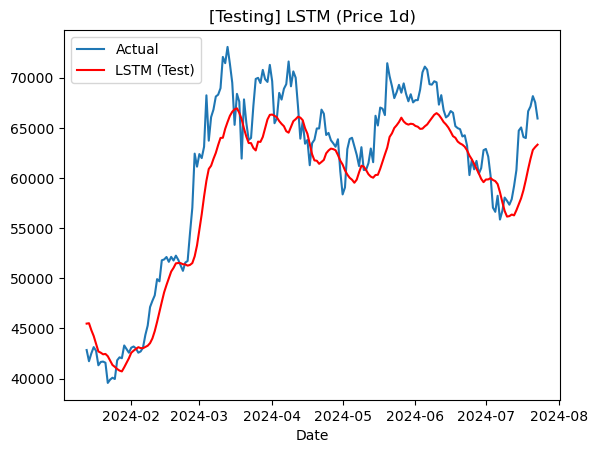

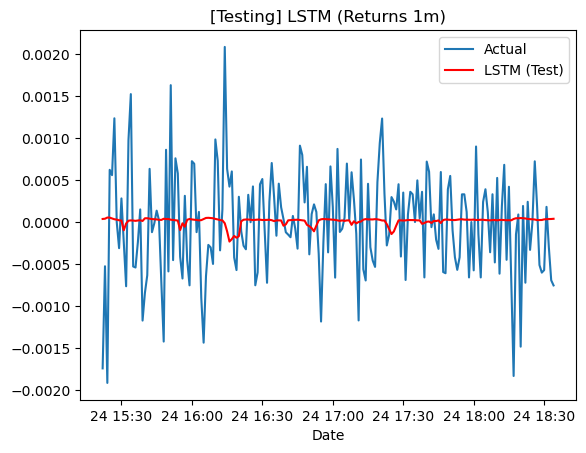

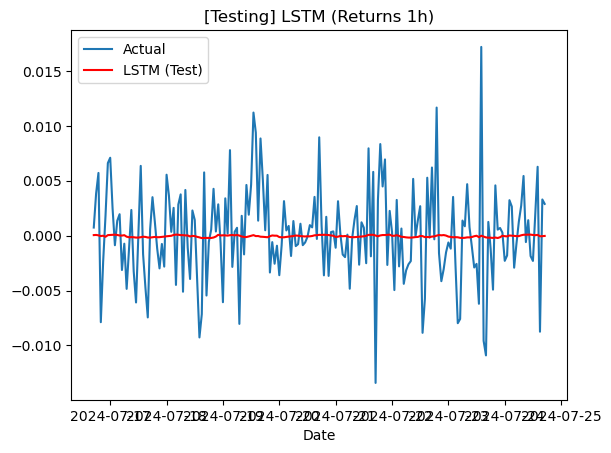

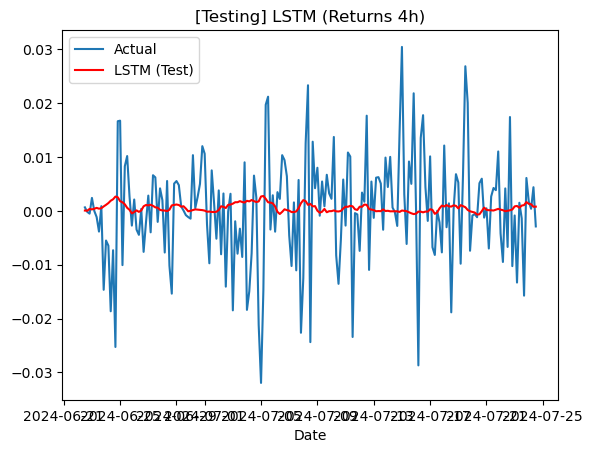

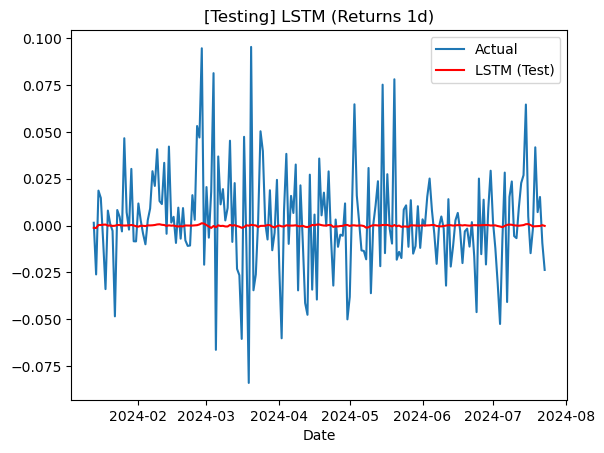

In [75]:
plot_forecast_result(lstm_preds_train_1m_price, lstm_preds_test_1m_price, df_1m['close'], 'LSTM (Price 1m)', 'test')
plot_forecast_result(lstm_preds_train_1h_price, lstm_preds_test_1h_price, df_1h['close'], 'LSTM (Price 1h)', 'test')
plot_forecast_result(lstm_preds_train_4h_price, lstm_preds_test_4h_price, df_4h['close'], 'LSTM (Price 4h)', 'test')
plot_forecast_result(lstm_preds_train_1d_price, lstm_preds_test_1d_price, df_1d['close'], 'LSTM (Price 1d)', 'test')

plot_forecast_result(lstm_preds_train_1m_returns, lstm_preds_test_1m_returns, df_1m['returns'], 'LSTM (Returns 1m)', 'test')
plot_forecast_result(lstm_preds_train_1h_returns, lstm_preds_test_1h_returns, df_1h['returns'], 'LSTM (Returns 1h)', 'test')
plot_forecast_result(lstm_preds_train_4h_returns, lstm_preds_test_4h_returns, df_4h['returns'], 'LSTM (Returns 4h)', 'test')
plot_forecast_result(lstm_preds_train_1d_returns, lstm_preds_test_1d_returns, df_1d['returns'], 'LSTM (Returns 1d)', 'test')

## Q-Learning